In [54]:
import filter 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import data_clean as dc 
from kalman import KalmanFilter

In [32]:
#load in data
pvss = os.listdir("data/")
gps = pd.read_csv("data/"+pvss[0])
left_gps = pd.read_csv("data/"+pvss[3])
right_gps = pd.read_csv("data/"+pvss[1])
df_labels = pd.read_csv("data/"+pvss[2])



In [26]:
label_names = pd.DataFrame(columns = ['road', 'condition','quality_right', 'quality_left','bumps'])

road_classes = ['dirt_road', 'cobblestone_road', 'asphalt_road']
quality_left_classes = ['good_road_left', 'regular_road_left', 'bad_road_left']
quality_right_classes = ['good_road_right', 'regular_road_right', 'bad_road_right']
condition_classes = ['paved_road', 'unpaved_road']
bump_classes=['no_speed_bump', 'speed_bump_asphalt', 'speed_bump_cobblestone']

# Convert from one-hot encoding to single label encoding
label_names = dc.ohe_to_label(df_labels, road_classes, label_names, 'road')
label_names = dc.ohe_to_label(df_labels, quality_right_classes, label_names, 'quality_right')
label_names = dc.ohe_to_label(df_labels, quality_left_classes, label_names, 'quality_left')
label_names = dc.ohe_to_label(df_labels, condition_classes, label_names, 'condition')
label_names = dc.ohe_to_label(df_labels, bump_classes, label_names, 'bumps')

# Convert road quality labels to numeric values
label_names = label_names.replace({'quality_right' : { 'good_road_right' : 2, 'regular_road_right' : 1, 'bad_road_right' : 0 }})
label_names = label_names.replace({'quality_left' : { 'good_road_left' : 2, 'regular_road_left' : 1, 'bad_road_left' : 0 }})
label_names['quality'] = label_names.loc[: , "quality_right":"quality_left"].mean(axis=1)
label_names = label_names.drop(columns = ["quality_right","quality_left"], axis = 1)

label_names.head()

,road,condition,bumps,quality
0,asphalt_road,paved_road,no_speed_bump,2.0
1,asphalt_road,paved_road,no_speed_bump,2.0
2,asphalt_road,paved_road,no_speed_bump,2.0
3,asphalt_road,paved_road,no_speed_bump,2.0
4,asphalt_road,paved_road,no_speed_bump,2.0


In [27]:
gps = dc.clean_gps(gps)
left_gps = dc.clean_acc(left_gps)
right_gps = dc.clean_acc(right_gps)

In [55]:
import cleaner

parent = '.data'

data_dict = cleaner.clean_dict(cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"]))

In [93]:
def build_z_dash(df, type="train", road="good_road_left"):
    """
    Builds a 1 column dataset from the given dictionary of dataframes
    timestamp
    latitude
    longitude
    elevation
    acc_x_dash_smooth
    acc_y_dash_smooth
    acc_z_dash_smooth

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    """
    result = None
    lengths = []
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder]
        labels = df[type]["labels"][folder][road]
        indices = labels[labels == 1].index

        new_data = pvsi.loc[indices]
        lengths.append(len(new_data))

        if result is None:
            result = new_data
        else:
            # append on the same column
            result = pd.concat([result, new_data], axis=0)

    return result, lengths
    


def build_gps_data(df, type="train"):
    """
    Builds a 6 column dataset from the given dataframe

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = {}
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder][["timestamp", "meters_latitude", "meters_longitude", "acc_x_dash_smooth", "acc_y_dash_smooth", "acc_z_dash_smooth"]]
        elevation = df[type]["t_gps"][folder][["timestamp", "meters_elevation"]]

        # merge the two dataframes on timestamp then remove timestamp
        pvsi = pd.merge(pvsi, elevation, on="timestamp")
        pvsi = pvsi.drop(columns=["timestamp"])

        result[folder] = pvsi
    return result


train_dict = {
    "good": build_z_dash(data_dict, type="train", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="train", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="train", road="bad_road_left")
}

test_dict = {
    "good": build_z_dash(data_dict, type="test", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="test", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="test", road="bad_road_left")
}

filter.add_smoothed_cols(data_dict, window=200)
filter.add_diff_cols(data_dict)

kal_data = build_gps_data(data_dict, type="train")
#print((data_dict["train"]["t_gps"]["PVS 1"]))

(1316, 17)
(1316, 17)
(1316, 17)
(1316, 17)
(1316, 19)
(1316, 21)
(1316, 23)
(1316, 25)
(1316, 27)
(1432, 17)
(1432, 17)
(1432, 17)
(1432, 17)
(1432, 19)
(1432, 21)
(1432, 23)
(1432, 25)
(1432, 27)
(1263, 17)
(1263, 17)
(1263, 17)
(1263, 17)
(1263, 19)
(1263, 21)
(1263, 23)
(1263, 25)
(1263, 27)
(1551, 17)
(1551, 17)
(1551, 17)
(1551, 17)
(1551, 19)
(1551, 21)
(1551, 23)
(1551, 25)
(1551, 27)
(1458, 17)
(1458, 17)
(1458, 17)
(1458, 17)
(1458, 19)
(1458, 21)
(1458, 23)
(1458, 25)
(1458, 27)
(915, 17)
(915, 17)
(915, 17)
(915, 17)
(915, 19)
(915, 21)
(915, 23)
(915, 25)
(915, 27)
(105816, 48)
(105816, 48)
(105816, 48)
(105816, 50)
(105816, 52)
(105816, 54)
(132492, 48)
(132492, 48)
(132492, 48)
(132492, 50)
(132492, 52)
(132492, 54)
(133877, 48)
(133877, 48)
(133877, 48)
(133877, 50)
(133877, 52)
(133877, 54)
(124684, 48)
(124684, 48)
(124684, 48)
(124684, 50)
(124684, 52)
(124684, 54)
(144036, 48)
(144036, 48)
(144036, 48)
(144036, 50)
(144036, 52)
(144036, 54)
(96279, 48)
(96279, 48)
(

In [530]:
print(data_dict)

KeyError: 'PVS 1'

In [371]:
print(kal_data["PVS 1"].columns)

Index(['meters_latitude', 'meters_longitude', 'acc_x_dash_smooth',
       'acc_y_dash_smooth', 'acc_z_dash_smooth', 'meters_elevation'],
      dtype='object')


## Kalman filter

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(9, 1024)
(6, 1024)


Text(0.5, 1.0, 'Z position')

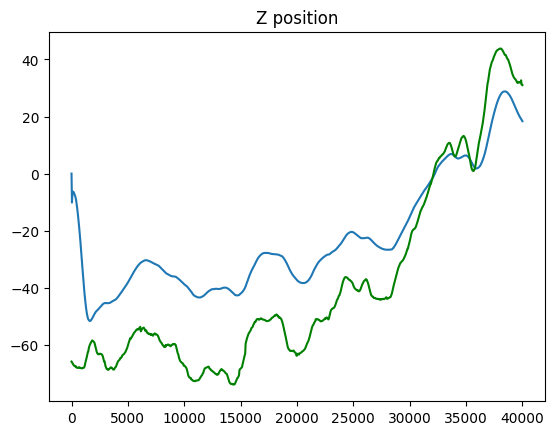

In [526]:
dt = 0.01


Q = np.eye(9) * 0.1
R = np.eye(6) * 3000

F = np.zeros((9, 9))
for i in range(6):
    F[i, i + 3] = dt
'''F = np.array([[1,0,0,.1,0,0,0,0,0],
            [0,1,0,0,.1,0,0,0,0],
            [0,0,1,0,0,.1,0,0,0],
            [1,0,0,1,0,0,.1,0,0],
            [1,0,0,.1,1,0,0,.1,0],
            [0,0,0,0,0,1,0,0,.1],
            [0,0,0,0,0,0,1,0,0],
            [0,0,0,0,0,0,0,1,0],
            [0,0,0,0,0,0,0,0,1]])'''
F = np.array([[1,0,0,.1,0,0,0,0,0],
            [0,1,0,0,.1,0,0,0,0],
            [0,0,1,0,0,.1,0,0,0],
            [0,0,0,1,0,0,.1,0,0],
            [0,0,0,0,1,0,0,.1,0],
            [0,0,0,0,0,1,0,0,.1],
            [0,0,0,0,0,0,1,0,0],
            [0,0,0,0,0,0,0,1,0],
            [0,0,0,0,0,0,0,0,1]])

G = np.zeros((9, 3))
for i in range(3):
    G[i + 6, i] = dt
G = np.ones((9,9))

H = np.zeros((6, 9))
for i in range(3):
    H[i, i] = 1
    H[i + 3, i + 6] = 0
   #H[i + 3, i + 6] = 0
print(H)
H = np.array([[1., 0, 0., 0., 0., 0., 0., 0., 0.],
            [0., 1, 0., 0., 0., 0., 0., 0., 0.,],
            [0., 0.,1, 0., 0., 0., 0, 0., 0.],
            [0., 0., 0., 0, 0, 0., 1., 0, 0],
            [0., 0., 0., 0, 0, 0., 0., 1., 0],
            [0., 0., 1, 0., 0., 0., 0., 0., 1]])

# initial state
x0 = np.zeros(9)
#x0[8] = -80
P0 = 1e5 * Q
#P0 = 1e-1 * Q
z = kal_data["PVS 1"].to_numpy().T
tsteps = 1000

# control u
u = np.zeros(9)
#u[8] = 1


kf = KalmanFilter(F, Q, H, R, G, u)
est = kf.estimate(x0, P0, z)

print(est.shape)
print(z.shape)

domain = np.linspace(0,40000,1024)
plt.plot(domain,est[2,:])
#plt.show()
#plt.plot(est[0,:],est[1,:], label = "Predicted", c = 'g')
plt.plot(domain,z[5,:], label = "Predicted", c = 'g')
plt.title("Z position")

# est = [posx, posy,posz,velx, vely,velz, accx, accy, accz]
# z = [lat, long, accx, accy, accz, z]



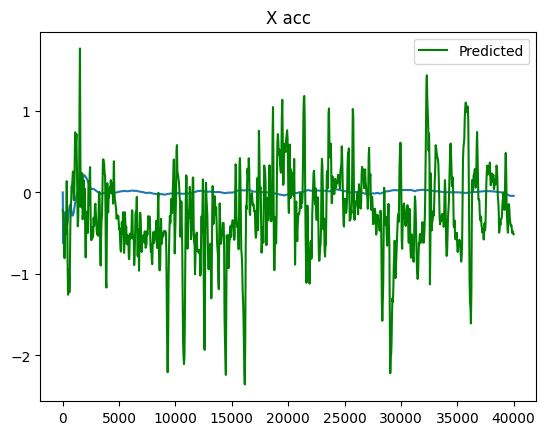

In [527]:
plt.plot(domain,est[6,:])
#plt.show()
#plt.plot(est[0,:],est[1,:], label = "Predicted", c = 'g')
plt.plot(domain,z[2,:], label = "Predicted", c = 'g')
plt.title("X acc")
plt.legend()

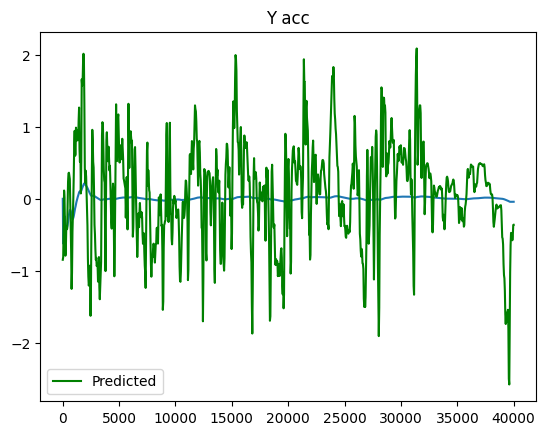

In [521]:
plt.plot(domain,est[7,:])
#plt.show()
#plt.plot(est[0,:],est[1,:], label = "Predicted", c = 'g')
plt.plot(domain,z[3,:], label = "Predicted", c = 'g')
plt.title("Y acc")
plt.legend()

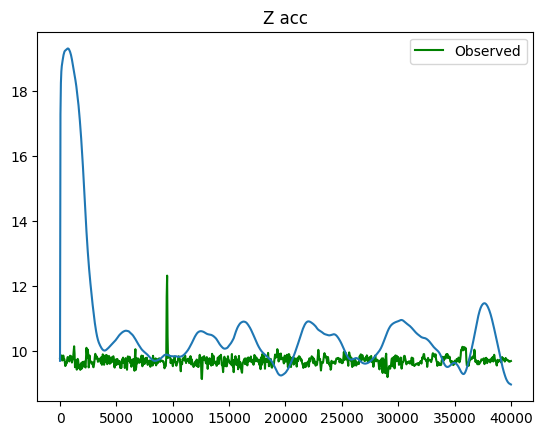

In [522]:
new = est[8,:] + 9.7
#plt.plot(domain,new)
#plt.show()
#plt.plot(est[0,:],est[1,:], label = "Predicted", c = 'g')
#new = z[4,:] + 9.8
plt.plot(domain,z[4,:], label = "Observed", c = 'g')
plt.plot(domain,new)
plt.title("Z acc")
plt.legend()

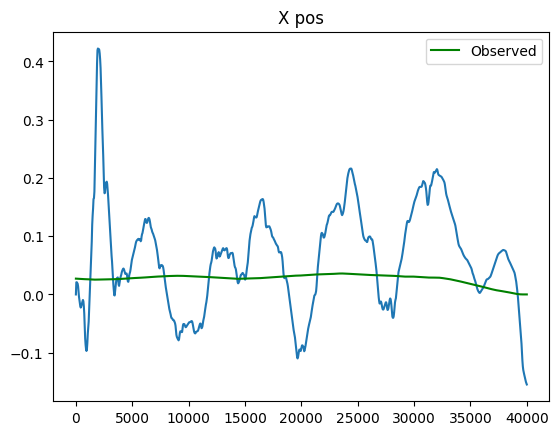

In [528]:
plt.plot(domain,est[0,:])
#plt.show()
#plt.plot(est[0,:],est[1,:], label = "Predicted", c = 'g')
plt.plot(domain,z[0,:], label = "Observed", c = 'g')
plt.title("X pos")
plt.legend()

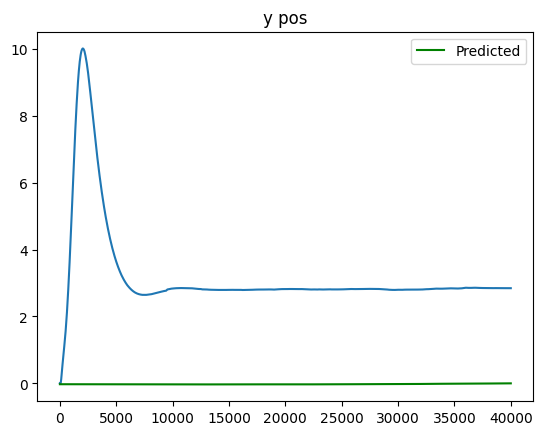

In [529]:
plt.plot(domain,est[1,:])
#plt.show()
#plt.plot(est[0,:],est[1,:], label = "Predicted", c = 'g')
plt.plot(domain,z[1,:], label = "Predicted", c = 'g')
plt.title("y pos")
plt.legend()

In [123]:
z = kal_data["PVS 1"]
print(z)

      meters_latitude  meters_longitude  acc_x_dash_smooth  acc_y_dash_smooth  \
0            0.027178         -0.026330          -0.217914          -0.847410   
1            0.027122         -0.026356          -0.264470          -0.809138   
2            0.027063         -0.026381          -0.331136          -0.360345   
3            0.027004         -0.026404          -0.595510           0.114952   
4            0.026952         -0.026428          -0.806619           0.015143   
...               ...               ...                ...                ...   
1019         0.000063         -0.000203          -0.461016          -0.490997   
1020         0.000068         -0.000206          -0.500598          -0.575949   
1021         0.000068         -0.000213          -0.479068          -0.513520   
1022         0.000064         -0.000207          -0.502902          -0.364481   
1023         0.000064         -0.000204          -0.512204          -0.361321   

      acc_z_dash_smooth  me

In [240]:
print(est[5,:])
print(z[5,:])

[ 0.         -0.02382587 -0.07166153 ... -0.14599799 -0.15382923
 -0.16105135]
[-65.89609926 -66.16768667 -66.43638344 ...  31.20975143  31.13271933
  31.00879293]


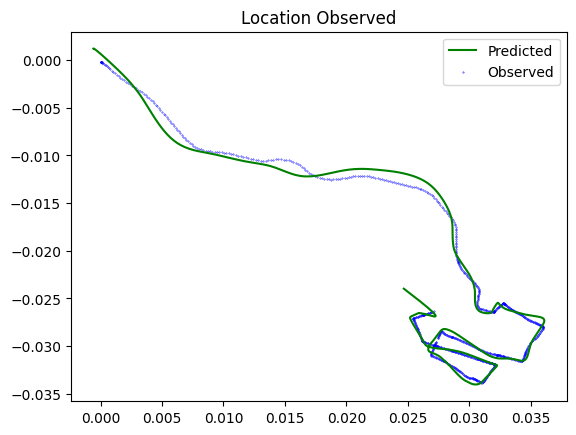

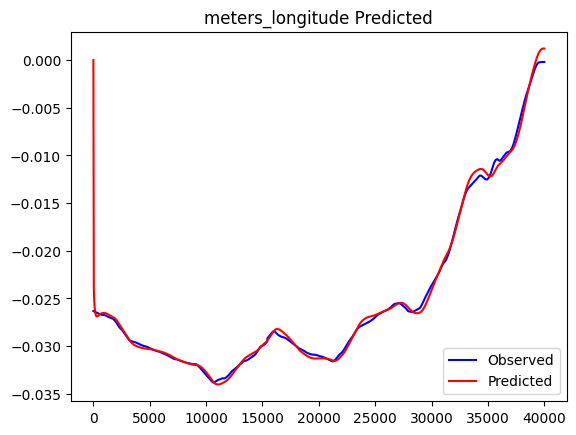

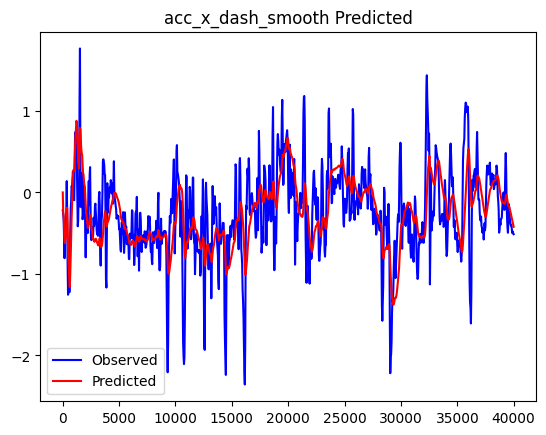

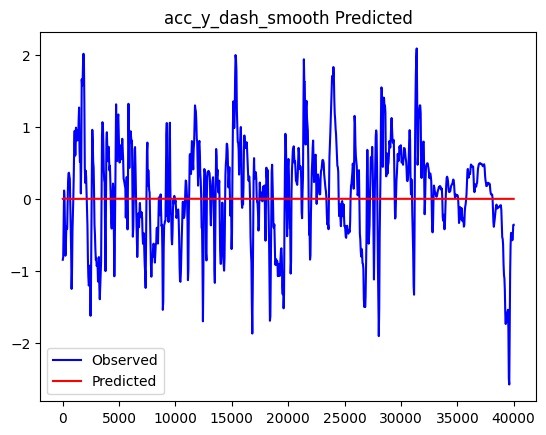

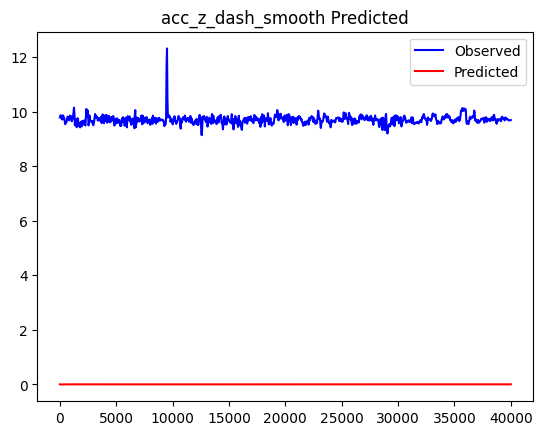

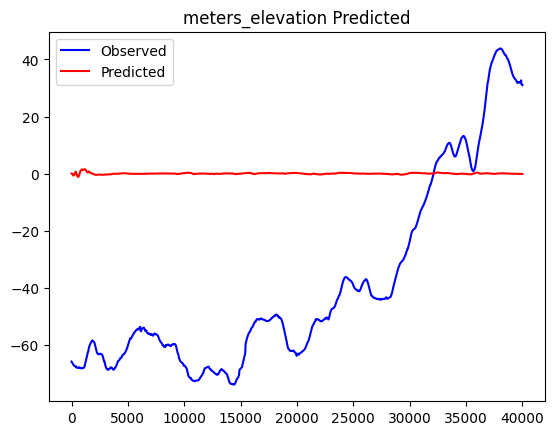

In [475]:
cols = kal_data["PVS 1"].columns 

for i in range(len(cols)):
    if i == 0:
        plt.plot(est[0,1:],est[1,1:], label = "Predicted", c = 'g')
        #plt.title("Location Predicted")
        #plt.show()
        plt.scatter(z[0,1:],z[1,1:], label = "Observed", c = 'b', s = .1)
        plt.title("Location Observed")
        plt.legend()
        plt.show()

    else:
        domain = np.linspace(0,40000,len(est[i,:]))
        plt.plot(domain,z[i,:], label = "Observed", c = 'b')
        plt.plot(domain,est[i,:], label = "Predicted", c = 'r')
        plt.title(cols[i]+" Predicted")
        #plt.show()
        #plt.plot(domain,z[i,:], label = "Observed", c = 'b')
        #plt.title(cols[i]+" Observed")
        plt.legend()
        plt.show()


In [60]:
print(est)

[[ 0.00000000e+00  2.98339891e-07  2.70625835e-07 ...  1.67082447e-09
   1.63397655e-09  1.63921309e-09]
 [ 0.00000000e+00 -2.89917824e-07 -2.63809600e-07 ... -1.02942086e-09
  -9.77978025e-10 -9.47852621e-10]
 [ 0.00000000e+00 -2.90916448e-06 -3.31136407e-06 ... -4.78936161e-06
  -5.02769858e-06 -5.12072829e-06]
 ...
 [ 0.00000000e+00  9.91908606e-04  9.96396537e-04 ...  9.94864787e-04
   9.96355177e-04  9.96386781e-04]
 [ 0.00000000e+00  1.09844364e-03  1.09872076e-03 ...  1.09678050e-03
   1.09689321e-03  1.09694289e-03]
 [ 0.00000000e+00  3.38323130e-04  3.35636162e-04 ...  1.31209750e-03
   1.31132718e-03  1.31008792e-03]]


In [41]:
print(kal_data["PVS 1"])

      meters_latitude  meters_longitude  acc_x_dash_smooth  acc_y_dash_smooth  \
0            0.027178         -0.026330          -0.217914          -0.847410   
1            0.027122         -0.026356          -0.264470          -0.809138   
2            0.027063         -0.026381          -0.331136          -0.360345   
3            0.027004         -0.026404          -0.595510           0.114952   
4            0.026952         -0.026428          -0.806619           0.015143   
...               ...               ...                ...                ...   
1019         0.000063         -0.000203          -0.461016          -0.490997   
1020         0.000068         -0.000206          -0.500598          -0.575949   
1021         0.000068         -0.000213          -0.479068          -0.513520   
1022         0.000064         -0.000207          -0.502902          -0.364481   
1023         0.000064         -0.000204          -0.512204          -0.361321   

      acc_z_dash_smooth  me

In [525]:
dt = 0.01


Q = np.eye(6) * 0.1
R = np.eye(6) * 1000

F = np.zeros((9, 9))
for i in range(6):
    F[i, i + 3] = dt
'''F = np.array([[1,0,0,.1,0,0,0,0,0],
            [0,1,0,0,.1,0,0,0,0],
            [0,0,1,0,0,.1,0,0,0],
            [1,0,0,1,0,0,.1,0,0],
            [1,0,0,.1,1,0,0,.1,0],
            [0,0,0,0,0,1,0,0,.1],
            [0,0,0,0,0,0,1,0,0],
            [0,0,0,0,0,0,0,1,0],
            [0,0,0,0,0,0,0,0,1]])'''
F = np.array([[1,0,0,0,0,0],
            [0,1,0,0,0,0],
            [0,0,1,0,0,0],
            [0,0,0,1,0,0],
            [0,0,0,0,1,0],
            [0,0,0,0,0,1]])


G = np.ones((6,6))

H = np.zeros((6, 6))
for i in range(6):
    H[i, i] = 1
    #H[i + 3, i + 6] = 0
   #H[i + 3, i + 6] = 0
print(H)
H = np.array([[1., 0, 0., 0., 0., 0., 0., 0., 0.],
            [0., 1, 0., 0., 0., 0., 0., 0., 0.,],
            [0., 0.,1, 0., 0., 0., 0, 0., 0.],
            [0., 0., 0., 0, 0, 0., 1., 0, 0],
            [0., 0., 0., 0, 0, 0., 0., 1., 0],
            [0., 0., 1, 0., 0., 0., 0., 0., 1]])

# initial state
x0 = np.zeros(6)
#x0[8] = -80
P0 = 1e5 * Q
#P0 = 1e-1 * Q
z = kal_data["PVS 1"].to_numpy().T
tsteps = 1000

# control u
u = np.zeros(6)
#u[8] = 1


kf = KalmanFilter(F, Q, H, R, G, u)
est = kf.estimate(x0, P0, z)

print(est.shape)
print(z.shape)

domain = np.linspace(0,40000,1024)
plt.plot(domain,est[2,:])
#plt.show()
#plt.plot(est[0,:],est[1,:], label = "Predicted", c = 'g')
plt.plot(domain,z[5,:], label = "Predicted", c = 'g')
plt.title("Z position")

# est = [posx, posy,posz,velx, vely,velz, accx, accy, accz]
# z = [lat, long, accx, accy, accz, z]

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 9)

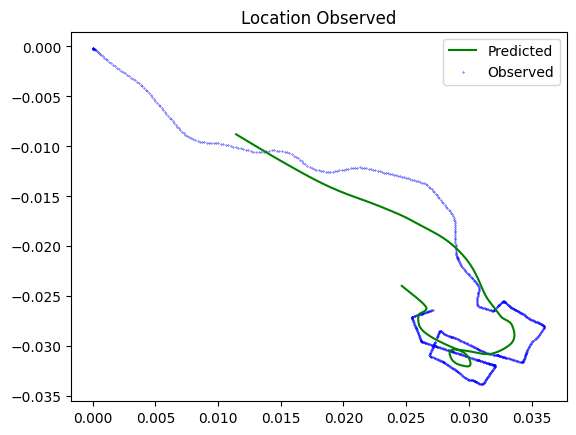

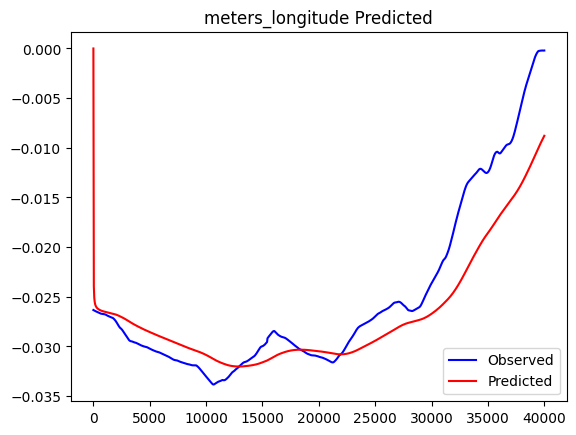

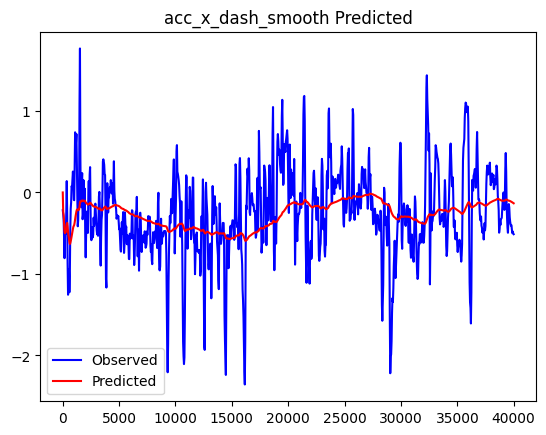

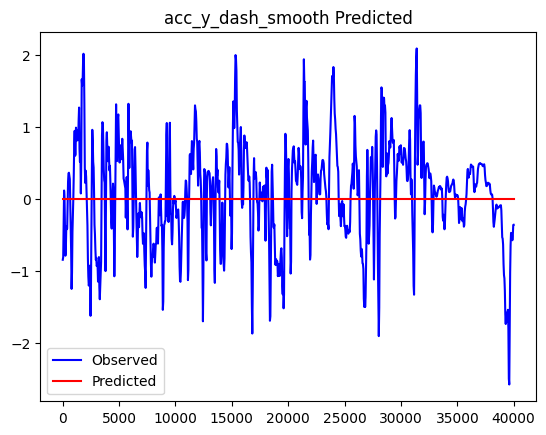

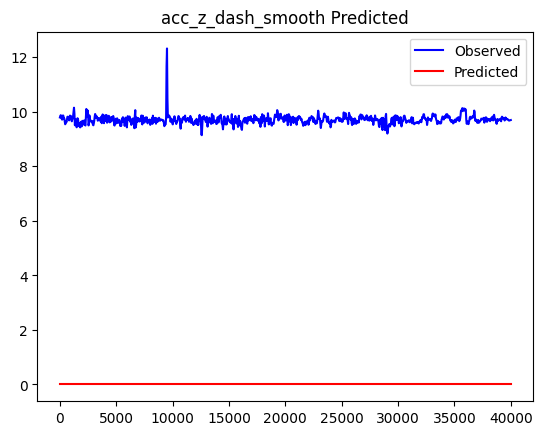

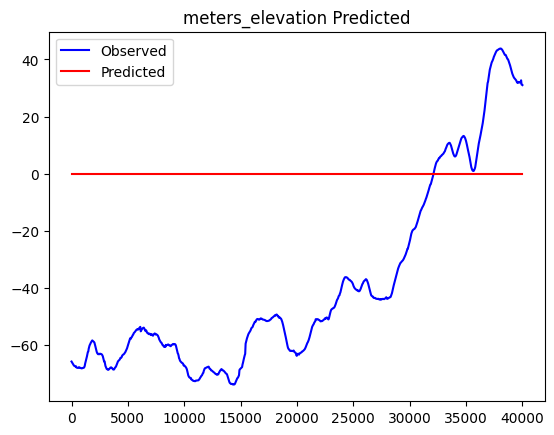

In [486]:
cols = kal_data["PVS 1"].columns 

for i in range(len(cols)):
    if i == 0:
        plt.plot(est[0,1:],est[1,1:], label = "Predicted", c = 'g')
        #plt.title("Location Predicted")
        #plt.show()
        plt.scatter(z[0,1:],z[1,1:], label = "Observed", c = 'b', s = .1)
        plt.title("Location Observed")
        plt.legend()
        plt.show()

    else:
        domain = np.linspace(0,40000,len(est[i,:]))
        plt.plot(domain,z[i,:], label = "Observed", c = 'b')
        plt.plot(domain,est[i,:], label = "Predicted", c = 'r')
        plt.title(cols[i]+" Predicted")
        #plt.show()
        #plt.plot(domain,z[i,:], label = "Observed", c = 'b')
        #plt.title(cols[i]+" Observed")
        plt.legend()
        plt.show()

## HMM review/testing

In [94]:
from hmmlearn import hmm

data_dict = cleaner.clean_dict(cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"]))
filter.add_smoothed_cols(data_dict, window=200)
filter.add_diff_cols(data_dict)

train_dict = {
    "good": build_z_dash(data_dict, type="train", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="train", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="train", road="bad_road_left")
}


test_dict = {
    "good": build_z_dash(data_dict, type="test", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="test", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="test", road="bad_road_left")
}

models = {}
num_models = 3
for key in train_dict.keys():
    data,lengths = train_dict[key]
    # make data an array
    data = data.values.reshape(-1, 1)
    # hmmlearn expects the data to be in a single array:
    # To separate the sequences, it requires the length of each:
    print("\nTraining for", key, end=": ")

    best_log = -np.inf
    for i in range(num_models):
        # Initialize and train the model
        model = hmm.GMMHMM(n_components=6, covariance_type="diag")
        model.fit(data, lengths=lengths)
        # Check the log-likelihood
        log_likelihood = model.monitor_.history[-1]
        if log_likelihood > best_log:
            best_log = log_likelihood
            best_model = model
        print(i, end=", ")
    models[key] = best_model

(1316, 11)
(1316, 13)
(1316, 15)
(1432, 11)
(1432, 13)
(1432, 15)
(1263, 11)
(1263, 13)
(1263, 15)
(1551, 11)
(1551, 13)
(1551, 15)
(1458, 11)
(1458, 13)
(1458, 15)
(915, 11)
(915, 13)
(915, 15)
(105816, 35)
(105816, 37)
(132492, 35)
(132492, 37)
(133877, 35)
(133877, 37)
(124684, 35)
(124684, 37)
(144036, 35)
(144036, 37)
(96279, 35)
(96279, 37)
(105816, 35)
(105816, 37)
(132492, 35)
(132492, 37)
(133877, 35)
(133877, 37)
(124684, 35)
(124684, 37)
(144036, 35)
(144036, 37)
(96279, 35)
(96279, 37)
(999, 11)
(999, 13)
(999, 15)
(91555, 35)
(91555, 37)
(91555, 35)
(91555, 37)
(1281, 11)
(1281, 13)
(1281, 15)
(1134, 11)
(1134, 13)
(1134, 15)
(128548, 35)
(128548, 37)
(123618, 35)
(123618, 37)
(128548, 35)
(128548, 37)
(123618, 35)
(123618, 37)

Training for good: 

ValueError: lengths array [50923, 50744, 53715, 56086, 56577, 40446] doesn't sum to 12031149 samples

In [ ]:
predicted_labels = model.predict(X)

def predict(mfcc_coeffs):
    """
    Predict the word from the given mfcc coefficients
    
    Parameters
    ----------
    mfcc_coeffs : ndarray of shape (M,)
        The mfcc coefficients for the word to be predicted
        
    Returns
    -------
    word : str
        The predicted word
    """
    # find the log probability density of the given mfcc coefficients
    log_prob = {}
    for key in models.keys():
        log_prob[key] = models[key].score(mfcc_coeffs)
    
    # return the word with the highest probability
    return max(log_prob, key=log_prob.get)



time_window = 10 # seconds
time_window *= 1000
for key in test_dict.keys():
    correct = 0
    incorrect = 0
    test_data, _ = test_dict[key]

    # iterate over test_data in groups of 10000
    test_data = test_data.values.reshape(-1, 1)
    for i in range(0, len(test_data), time_window):
        item = test_data[i:i+time_window]
        prediction = predict(item)
        if prediction == key:
            correct += 1
        elif prediction == "good" and key == "regular":
            correct += 1
        elif prediction == "regular" and key == "good":
            correct += 1
        else:
            incorrect += 1
    
    print("Accuracy for", key, ":", correct/(correct+incorrect))

In [ ]:
# how many times does predicted_labels switch form 0 to 1
switches = 0
for i in range(1, len(predicted_labels)):
    if predicted_labels[i] != predicted_labels[i-1]:
        switches += 1

print(f"Switches: {switches}")
print(f"Lenght of labels: {len(predicted_labels)}") 
print(f"Ratio: {switches/len(predicted_labels)}")

# plot the predicted labels
start = 20000
end = 21000
diff = 1000
plt.figure(figsize=(20, 20))
p = 1
while p < 20:
    plt.subplot(5, 4, max(p,1))
    p += 1
    start += diff
    end += diff   
    a = predicted_labels[start:end]
    # count how many zeros
    zeros = np.count_nonzero(a == 0)
    # print("Zeros: ", zeros)
    # print("P:", p)
    if zeros == 0:
        p -= 1
        continue
    plt.scatter(np.arange(diff), predicted_labels[start:end])
    plt.plot(np.arange(diff), hmm_true['paved_road'][start:end], color='red')
    plt.plot(np.arange(diff), X[start:end, 0]-9.5, color='green')
    plt.title(f"Second {end/1000}, Zeros: {zeros}")
    # remove axis ticks
    # plt.xticks([])
    # plt.yticks([])

# reduce space between subplots
plt.tight_layout()
plt.show()

## Random Forest/Last semester: predicting road quality 

In [540]:
print(df_labels.columns)

pvss = os.listdir(".data/")
print(pvss)
gps3 = pd.read_csv(".data/"+pvss[0]+'/dataset_gps.csv')
left_gps3 = pd.read_csv(".data/"+pvss[0]+'/dataset_gps_mpu_left.csv')
right_gps3 = pd.read_csv(".data/"+pvss[0]+'/dataset_gps_mpu_right.csv')
df_labels3 = pd.read_csv(".data/"+pvss[0]+'/dataset_labels.csv')

pvss = os.listdir("data/")
gps1 = pd.read_csv("data/"+pvss[0])
left_gps1 = pd.read_csv("data/"+pvss[3])
right_gps1 = pd.read_csv("data/"+pvss[1])
df_labels1 = pd.read_csv("data/"+pvss[2])


def get_labels(index):

    ['PVS 3', 'PVS 4', 'PVS 5', 'PVS 2', 'PVS 9', 'PVS 7', 'PVS 1', 'PVS 6', 'PVS 8']

    pvss = os.listdir(".data/")
    gps3 = pd.read_csv(".data/"+pvss[index]+'/dataset_gps.csv')
    left_gps3 = pd.read_csv(".data/"+pvss[index]+'/dataset_gps_mpu_left.csv')
    right_gps3 = pd.read_csv(".data/"+pvss[index]+'/dataset_gps_mpu_right.csv')
    df_labels3 = pd.read_csv(".data/"+pvss[index]+'/dataset_labels.csv')

    return df_labels3



#df_labels = pd.concat([df_labels3, df_labels1], ignore_index=True)


Index(['paved_road', 'unpaved_road', 'dirt_road', 'cobblestone_road',
       'asphalt_road', 'no_speed_bump', 'speed_bump_asphalt',
       'speed_bump_cobblestone', 'good_road_left', 'regular_road_left',
       'bad_road_left', 'good_road_right', 'regular_road_right',
       'bad_road_right'],
      dtype='object')
['PVS 3', 'PVS 4', 'PVS 5', 'PVS 2', 'PVS 9', 'PVS 7', 'PVS 1', 'PVS 6', 'PVS 8']


In [539]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# TRAIN ON PVSS 1 AND TEST ON PVSS 3 

clf = RandomForestClassifier(max_depth=2, random_state=0)
y_train = df_labels1['no_speed_bump'].values
X_train = df_labels1.drop(['no_speed_bump', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)

y_test = df_labels3['no_speed_bump'].values
X_test = df_labels3.drop(['no_speed_bump', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)

print(acc)

0.9942447266953958


In [538]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# MERGE PVSS 1 AND PVSS 3 AND TRAIN/TEST WITH BOTH  

clf = RandomForestClassifier(max_depth=2, random_state=0)
y = df_labels['no_speed_bump'].values
X = df_labels.drop(['no_speed_bump', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)

print(acc)




0.9838208897297822


In [619]:
df_labels5 = get_labels(1)
df_labels9 = get_labels(4)

clf = RandomForestClassifier(max_depth=2, random_state=0)
y_train = df_labels5['no_speed_bump'].values
X_train = df_labels5.drop(['no_speed_bump', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)

y_test = df_labels9['no_speed_bump'].values
X_test = df_labels9.drop(['no_speed_bump', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
print(X_train)
answer = clf.predict(X_test)



acc = clf.score(X_test, y_test)

print(acc)



        paved_road  unpaved_road  dirt_road  cobblestone_road  asphalt_road  \
0                1             0          0                 0             1   
1                1             0          0                 0             1   
2                1             0          0                 0             1   
3                1             0          0                 0             1   
4                1             0          0                 0             1   
...            ...           ...        ...               ...           ...   
132487           1             0          0                 0             1   
132488           1             0          0                 0             1   
132489           1             0          0                 0             1   
132490           1             0          0                 0             1   
132491           1             0          0                 0             1   

        good_road_left  regular_road_left  bad_road

In [ ]:
df_labels5 = get_labels(1)
df_labels9 = get_labels(4)

clf = RandomForestClassifier(max_depth=2, random_state=0)
y_train = df_labels5['no_speed_bump'].values
X_train = df_labels5.drop(['no_speed_bump', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)

y_test = df_labels9['no_speed_bump'].values
X_test = df_labels9.drop(['no_speed_bump', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
answer = clf.predict(X_test)



acc = clf.score(X_test, y_test)

print(acc)

In [613]:
['paved_road', 'unpaved_road', 'dirt_road', 'cobblestone_road',
       'asphalt_road', 'no_speed_bump', 'speed_bump_asphalt',
       'speed_bump_cobblestone', 'good_road_left', 'regular_road_left',
       'bad_road_left', 'good_road_right', 'regular_road_right',
       'bad_road_right']

df_labels5 = get_labels(2)
df_labels9 = get_labels(4)

clf = RandomForestClassifier(max_depth=2, random_state=0)
y_train = df_labels5[['dirt_road', 'cobblestone_road', 'asphalt_road']]
X_train = df_labels5.drop(['dirt_road', 'cobblestone_road', 'asphalt_road', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)

y_train = df_labels9[['dirt_road', 'cobblestone_road', 'asphalt_road']]
X_train = df_labels9.drop(['dirt_road', 'cobblestone_road', 'asphalt_road', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)

print(acc)



/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: Classification metrics can't handle a mix of continuous and multilabel-indicator targets

In [625]:


datas_X = []
datas_Y = []
for i in range(9):

    df_labels = get_labels(i)
    #merged_df = pd.merge(gps, left_gps, on='timestamp', how='inner')
    #merged_df = pd.merge(merged_df, right_gps, on='timestamp', how='inner')
    y_train = df_labels['no_speed_bump'].values
    X_train = df_labels.drop(['no_speed_bump', 'speed_bump_asphalt','speed_bump_cobblestone'], axis = 1)
    
    datas_X.append(X_train)
    datas_Y.append(y_train)
    
big_X = np.concatenate(datas_X)
big_Y = np.concatenate(datas_Y)

clf = RandomForestClassifier(max_depth=None, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(big_X, big_Y, test_size=0.40, random_state=42)

print(X_train)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
pred = clf.predict(X_test)

for i in range(len(pred)):
    if pred[i] != 1:
        print(pred[i],y_test[i])

print(acc)

    

[[1 0 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 ...
 [0 1 1 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]]
0.9842516224830119


## Speed/gyro column stuff

I wanted to do something with the quality but I am sure how to merge the quality and the speed data...

In [603]:
# Affect of road quality on the speed 

'''pvss = os.listdir("data/")
gps = pd.read_csv("data/"+pvss[0])
left_gps = pd.read_csv("data/"+pvss[3])
right_gps = pd.read_csv("data/"+pvss[1])
df_labels = pd.read_csv("data/"+pvss[2])'''

def get_gps_data(index):

    ['PVS 3', 'PVS 4', 'PVS 5', 'PVS 2', 'PVS 9', 'PVS 7', 'PVS 1', 'PVS 6', 'PVS 8']

    pvss = os.listdir(".data/")
    gps3 = pd.read_csv(".data/"+pvss[index]+'/dataset_gps.csv')
    left_gps3 = pd.read_csv(".data/"+pvss[index]+'/dataset_gps_mpu_left.csv')
    right_gps3 = pd.read_csv(".data/"+pvss[index]+'/dataset_gps_mpu_right.csv')
    df_labels3 = pd.read_csv(".data/"+pvss[index]+'/dataset_labels.csv')

    return gps3, left_gps3, right_gps3

datas_X = []
datas_Y = []
for i in range(9):

    gps3, left_gps3, right_gps3 = get_gps_data(i)
    merged_df = pd.merge(gps, left_gps, on='timestamp', how='inner')
    #merged_df = pd.merge(merged_df, right_gps, on='timestamp', how='inner')
    y = merged_df['speed_meters_per_second']
    X = merged_df.drop(['timestamp', 'latitude_x', 'longitude_x', 'elevation', 'accuracy',
       'bearing', 'speed_meters_per_second', 'satellites', 'provider', 'hdop',
       'vdop', 'pdop', 'geoidheight', 'ageofdgpsdata', 'dgpsid', 'activity',
       'battery', 'annotation', 'distance_meters', 'elapsed_time_seconds',
       'acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard',
       'acc_x_above_suspension', 'acc_y_above_suspension',
       'acc_z_above_suspension', 'acc_x_below_suspension',
       'acc_y_below_suspension', 'acc_z_below_suspension', 'mag_x_dashboard', 'mag_y_dashboard',
       'mag_z_dashboard', 'mag_x_above_suspension', 'mag_y_above_suspension',
       'mag_z_above_suspension', 'temp_dashboard', 'temp_above_suspension',
       'temp_below_suspension', 'timestamp_gps', 'latitude_y', 'longitude_y',
       'speed'], axis = 1)
    
    datas_X.append(X)
    datas_Y.append(y)
    
big_X = np.concatenate(datas_X)
#big_X.reset_index(drop=True, inplace=True)
big_Y = np.concatenate(datas_Y)




In [601]:
merged_df = pd.merge(gps, left_gps, on='timestamp', how='inner')
#merged_df = pd.merge(merged_df, right_gps, on='timestamp', how='inner')

In [630]:
print(len(gps))
print(len(left_gps))
print(len(merged_df))

1467
144036
1024


In [602]:
print(merged_df.columns)

Index(['timestamp', 'latitude_x', 'longitude_x', 'elevation', 'accuracy',
       'bearing', 'speed_meters_per_second', 'satellites', 'provider', 'hdop',
       'vdop', 'pdop', 'geoidheight', 'ageofdgpsdata', 'dgpsid', 'activity',
       'battery', 'annotation', 'distance_meters', 'elapsed_time_seconds',
       'acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard',
       'acc_x_above_suspension', 'acc_y_above_suspension',
       'acc_z_above_suspension', 'acc_x_below_suspension',
       'acc_y_below_suspension', 'acc_z_below_suspension', 'gyro_x_dashboard',
       'gyro_y_dashboard', 'gyro_z_dashboard', 'gyro_x_above_suspension',
       'gyro_y_above_suspension', 'gyro_z_above_suspension',
       'gyro_x_below_suspension', 'gyro_y_below_suspension',
       'gyro_z_below_suspension', 'mag_x_dashboard', 'mag_y_dashboard',
       'mag_z_dashboard', 'mag_x_above_suspension', 'mag_y_above_suspension',
       'mag_z_above_suspension', 'temp_dashboard', 'temp_above_suspension',
       'temp

In [594]:
#combined left right and gps

y = merged_df['speed_meters_per_second']
X = merged_df.drop(['timestamp', 'latitude_x', 'longitude_x', 'elevation', 'accuracy',
       'bearing', 'speed_meters_per_second', 'satellites', 'provider', 'hdop',
       'vdop', 'pdop', 'geoidheight', 'ageofdgpsdata', 'dgpsid', 'activity',
       'battery', 'annotation', 'distance_meters', 'elapsed_time_seconds',
       'acc_x_dashboard_x', 'acc_y_dashboard_x', 'acc_z_dashboard_x',
       'acc_x_above_suspension_x', 'acc_y_above_suspension_x',
       'acc_z_above_suspension_x', 'acc_x_below_suspension_x',
       'acc_y_below_suspension_x', 'acc_z_below_suspension_x',
       'mag_x_dashboard_x', 'mag_y_dashboard_x', 'mag_z_dashboard_x',
       'mag_x_above_suspension_x', 'mag_y_above_suspension_x',
       'mag_z_above_suspension_x', 'temp_dashboard_x',
       'temp_above_suspension_x', 'temp_below_suspension_x', 'timestamp_gps_x',
       'latitude_y', 'longitude_y', 'speed_x', 'acc_x_dashboard_y',
       'acc_y_dashboard_y', 'acc_z_dashboard_y', 'acc_x_above_suspension_y',
       'acc_y_above_suspension_y', 'acc_z_above_suspension_y',
       'acc_x_below_suspension_y', 'acc_y_below_suspension_y',
       'acc_z_below_suspension_y', 'mag_x_dashboard_y', 'mag_y_dashboard_y',
       'temp_dashboard_y', 'temp_above_suspension_y',
       'temp_below_suspension_y', 'timestamp_gps_y', 'latitude', 'longitude',
       'speed_y','mag_z_dashboard_y', 'mag_x_above_suspension_y',
       'mag_y_above_suspension_y', 'mag_z_above_suspension_y'], axis = 1)

print(X.columns)

Index(['gyro_x_dashboard_x', 'gyro_y_dashboard_x', 'gyro_z_dashboard_x',
       'gyro_x_above_suspension_x', 'gyro_y_above_suspension_x',
       'gyro_z_above_suspension_x', 'gyro_x_below_suspension_x',
       'gyro_y_below_suspension_x', 'gyro_z_below_suspension_x',
       'gyro_x_dashboard_y', 'gyro_y_dashboard_y', 'gyro_z_dashboard_y',
       'gyro_x_above_suspension_y', 'gyro_y_above_suspension_y',
       'gyro_z_above_suspension_y', 'gyro_x_below_suspension_y',
       'gyro_y_below_suspension_y', 'gyro_z_below_suspension_y'],
      dtype='object')


In [581]:
print(gps.columns)

Index(['timestamp', 'latitude', 'longitude', 'elevation', 'accuracy',
       'bearing', 'speed_meters_per_second', 'satellites', 'provider', 'hdop',
       'vdop', 'pdop', 'geoidheight', 'ageofdgpsdata', 'dgpsid', 'activity',
       'battery', 'annotation', 'distance_meters', 'elapsed_time_seconds'],
      dtype='object')


In [627]:
print(gps['speed_meters_per_second'].values[500:600])

[7.48795    7.2818995  6.9691343  6.342078   4.999085   4.02523
 4.00114    4.470934   5.456931   6.2319627  6.765364   7.1519322
 7.375417   6.967889   6.743336   6.78069    6.7529097  6.848665
 7.1440897  7.295948   7.46828    7.165563   6.9735584  6.6513443
 5.797363   4.3612967  3.3442554  1.4964347  0.869755   0.81331235
 1.8308511  2.0049622  2.447193   2.8090227  2.9283836  3.4851563
 3.7777736  4.1044626  3.8973236  4.016648   4.6087008  5.124711
 5.632886   6.0965514  6.404574   6.8333154  6.784313   6.784113
 6.8194733  6.806637   6.4146667  5.9765153  5.4246655  5.166358
 4.915693   4.8573823  4.85467    4.35349    3.0176191  2.1587076
 2.076356   2.7486327  4.177631   4.170619   4.5528355  5.1897416
 5.8739014  6.588729   7.1241207  7.2467203  7.2169504  7.085963
 7.068467   6.8439517  6.6021905  6.5421143  6.485202   6.5071363
 6.391133   6.092296   5.9393587  5.585737   5.2632637  4.9395447
 4.2421126  3.9097269  3.979015   3.4271662  2.354952   2.5939918
 3.6316366  3.90

In [ ]:
y = gps['speed_meters_per_second']
X = gps.drop(['timestamp', 'latitude_x', 'longitude_x', 'elevation', 'accuracy',
       'bearing', 'speed_meters_per_second', 'satellites', 'provider', 'hdop',
       'vdop', 'pdop', 'geoidheight', 'ageofdgpsdata', 'dgpsid', 'activity',
       'battery', 'annotation', 'distance_meters', 'elapsed_time_seconds',
       'acc_x_dashboard_x', 'acc_y_dashboard_x', 'acc_z_dashboard_x',
       'acc_x_above_suspension_x', 'acc_y_above_suspension_x',
       'acc_z_above_suspension_x', 'acc_x_below_suspension_x',
       'acc_y_below_suspension_x', 'acc_z_below_suspension_x',
       'mag_x_dashboard_x', 'mag_y_dashboard_x', 'mag_z_dashboard_x',
       'mag_x_above_suspension_x', 'mag_y_above_suspension_x',
       'mag_z_above_suspension_x', 'temp_dashboard_x',
       'temp_above_suspension_x', 'temp_below_suspension_x', 'timestamp_gps_x',
       'latitude_y', 'longitude_y', 'speed_x', 'acc_x_dashboard_y',
       'acc_y_dashboard_y', 'acc_z_dashboard_y', 'acc_x_above_suspension_y',
       'acc_y_above_suspension_y', 'acc_z_above_suspension_y',
       'acc_x_below_suspension_y', 'acc_y_below_suspension_y',
       'acc_z_below_suspension_y', 'mag_x_dashboard_y', 'mag_y_dashboard_y',
       'temp_dashboard_y', 'temp_above_suspension_y',
       'temp_below_suspension_y', 'timestamp_gps_y', 'latitude', 'longitude',
       'speed_y','mag_z_dashboard_y', 'mag_x_above_suspension_y',
       'mag_y_above_suspension_y', 'mag_z_above_suspension_y'], axis = 1)

print(len(X))

In [595]:
print(len(big_X))

9216


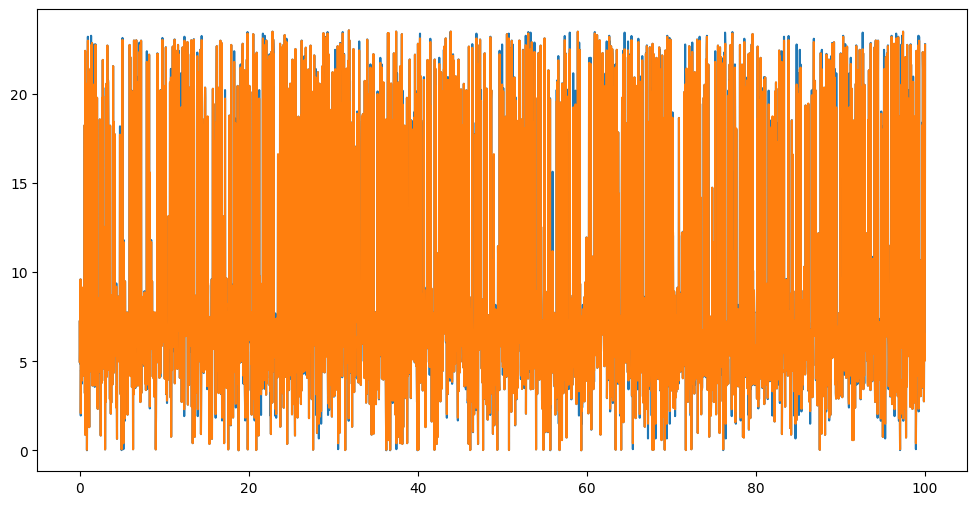

0.997478726933355


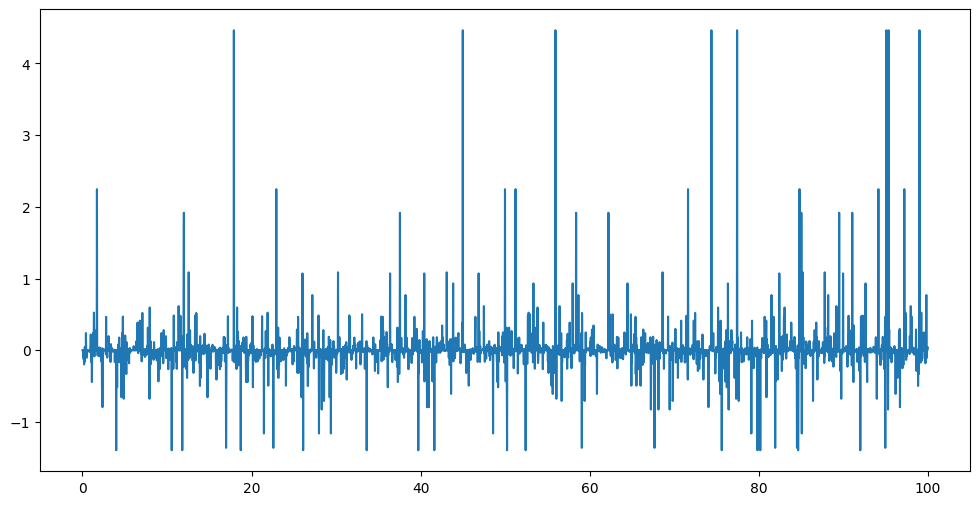

In [604]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(big_X, big_Y, test_size=0.4, random_state=42)

rf_regress = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regress.fit(X_train, y_train)

acc = rf_regress.score(X_test, y_test)
y_pred = rf_regress.predict(X_test)

domain = np.linspace(0,100,len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(domain,y_test)
plt.plot(domain, y_pred)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(domain, y_test-y_pred)

print(acc)


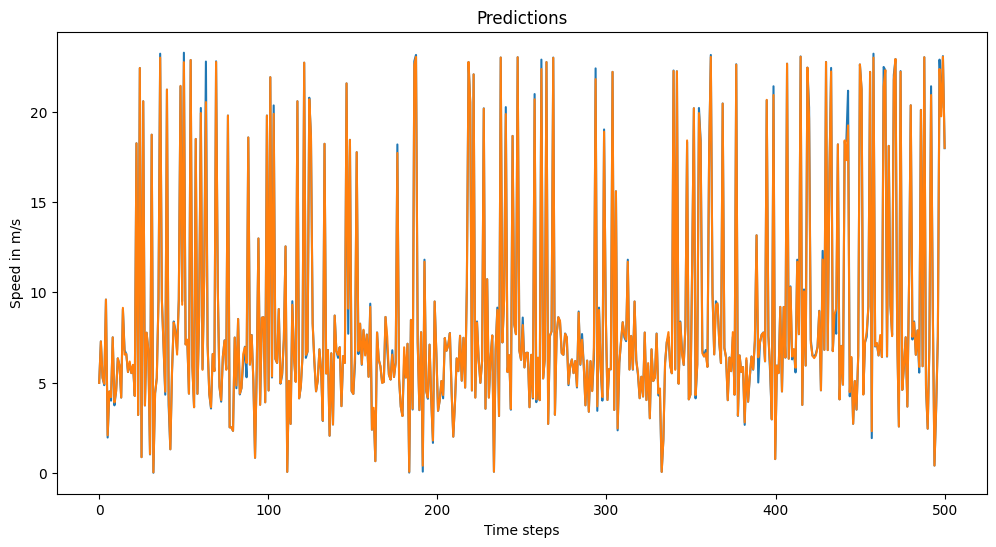

Text(0.5, 1.0, 'Error')

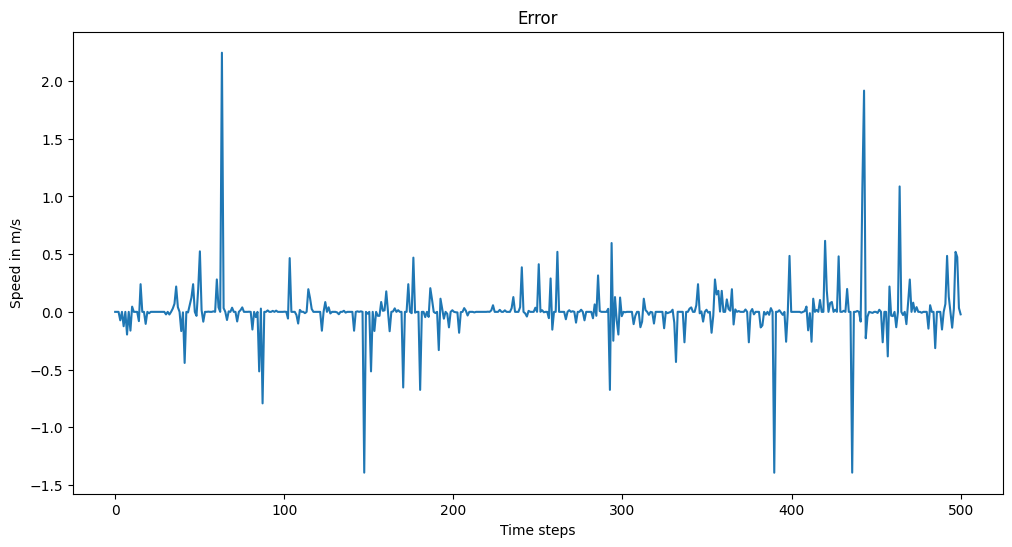

In [607]:
domain = np.linspace(0,len(y_test[:500]),len(y_test[:500]))
plt.figure(figsize=(12, 6))
plt.plot(domain,y_test[:500])
plt.plot(domain, y_pred[:500])
plt.ylabel("Speed in m/s")
plt.xlabel("Time steps")
plt.title("Predictions")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(domain, y_test[:500]-y_pred[:500])
plt.ylabel("Speed in m/s")
plt.xlabel("Time steps")
plt.title("Error")